In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn joblib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import joblib

# Load the dataset (replace with your file name if different)
df = pd.read_csv('crime_dataset_india.csv')

# Display basic info
print("Dataset Shape:", df.shape)
print("\nFirst 5 Rows:")
print(df.head())
print("\nColumns:", list(df.columns))
print("\nMissing Values Before Handling:")
print(df.isnull().sum())

Dataset Shape: (40160, 14)

First 5 Rows:
   Report Number     Date Reported Date of Occurrence Time of Occurrence  \
0              1  02-01-2020 00:00   01-01-2020 00:00   01-01-2020 01:11   
1              2  01-01-2020 19:00   01-01-2020 01:00   01-01-2020 06:26   
2              3  02-01-2020 05:00   01-01-2020 02:00   01-01-2020 14:30   
3              4  01-01-2020 05:00   01-01-2020 03:00   01-01-2020 14:46   
4              5  01-01-2020 21:00   01-01-2020 04:00   01-01-2020 16:51   

        City  Crime Code Crime Description  Victim Age Victim Gender  \
0  Ahmedabad         576    IDENTITY THEFT          16             M   
1    Chennai         128          HOMICIDE          37             M   
2   Ludhiana         271        KIDNAPPING          48             F   
3       Pune         170          BURGLARY          49             F   
4       Pune         421         VANDALISM          30             F   

    Weapon Used   Crime Domain  Police Deployed Case Closed  Date Ca

In [6]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import pandas as pd

# (Assume df is loaded; reload if needed)
# df = pd.read_csv('your_dataset.csv')  # Replace with actual file name

# Print types to debug
print("Column Types Before Processing:")
print(df.dtypes)

# 1. Handle Missing Values
# Numerical columns: Impute with median (if any)
num_cols = df.select_dtypes(include=np.number).columns
if len(num_cols) > 0:
    imputer_num = SimpleImputer(strategy='median')
    df[num_cols] = imputer_num.fit_transform(df[num_cols])
else:
    print("No numerical columns found — skipping numerical imputation.")

# Categorical columns: Impute with mode (if any)
cat_cols = df.select_dtypes(include='object').columns
if len(cat_cols) > 0:
    imputer_cat = SimpleImputer(strategy='most_frequent')
    df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])
else:
    print("No categorical columns found — skipping categorical imputation.")

print("\nMissing Values After Handling:")
print(df.isnull().sum())

# 2. Encode Categorical Columns (only if any exist)
if len(cat_cols) > 0:
    le = LabelEncoder()
    for col in cat_cols:
        df[col] = le.fit_transform(df[col])
else:
    print("No categorical columns to encode.")

# 3. Normalize Numerical Features (if any)
if len(num_cols) > 0:
    scaler = StandardScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])
else:
    print("No numerical columns to normalize.")

# 4. Create Derived Targets (using 'Police Deployed' as proxy for crime rate)
# Aggregate to get 'Crime Count' per 'City' (proxy for rate)
if 'City' in df.columns:
    df_agg = df.groupby('City').size().reset_index(name='Crime Count')
    df = df.merge(df_agg, on='City', how='left')
else:
    print("Warning: 'City' column not found — skipping aggregation. Using 'Police Deployed' directly.")

# Regression target: Use 'Crime Count' if created, else 'Police Deployed'
if 'Crime Count' in df.columns:
    crime_rate_col = 'Crime Count'
else:
    crime_rate_col = 'Police Deployed'  # Fallback — replace with another numerical column if better

# Create classification target (high/low crime-prone)
median_rate = df[crime_rate_col].median()
df['Crime Prone'] = np.where(df[crime_rate_col] > median_rate, 1, 0)  # 1 = High, 0 = Low

print("\nData after Preprocessing:")
print(df.head())

Column Types Before Processing:
Report Number         float64
Date Reported         float64
Date of Occurrence    float64
Time of Occurrence    float64
City                  float64
Crime Code            float64
Crime Description     float64
Victim Age            float64
Victim Gender         float64
Weapon Used           float64
Crime Domain          float64
Police Deployed       float64
Case Closed           float64
Date Case Closed      float64
dtype: object
No categorical columns found — skipping categorical imputation.

Missing Values After Handling:
Report Number         0
Date Reported         0
Date of Occurrence    0
Time of Occurrence    0
City                  0
Crime Code            0
Crime Description     0
Victim Age            0
Victim Gender         0
Weapon Used           0
Crime Domain          0
Police Deployed       0
Case Closed           0
Date Case Closed      0
dtype: int64
No categorical columns to encode.

Data after Preprocessing:
   Report Number  Date Repor

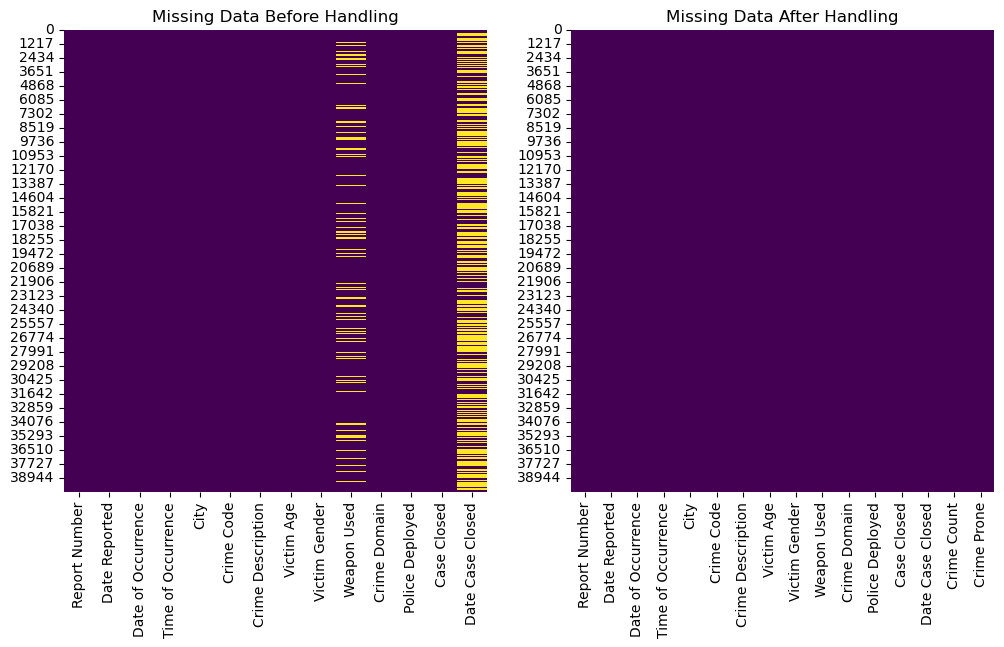

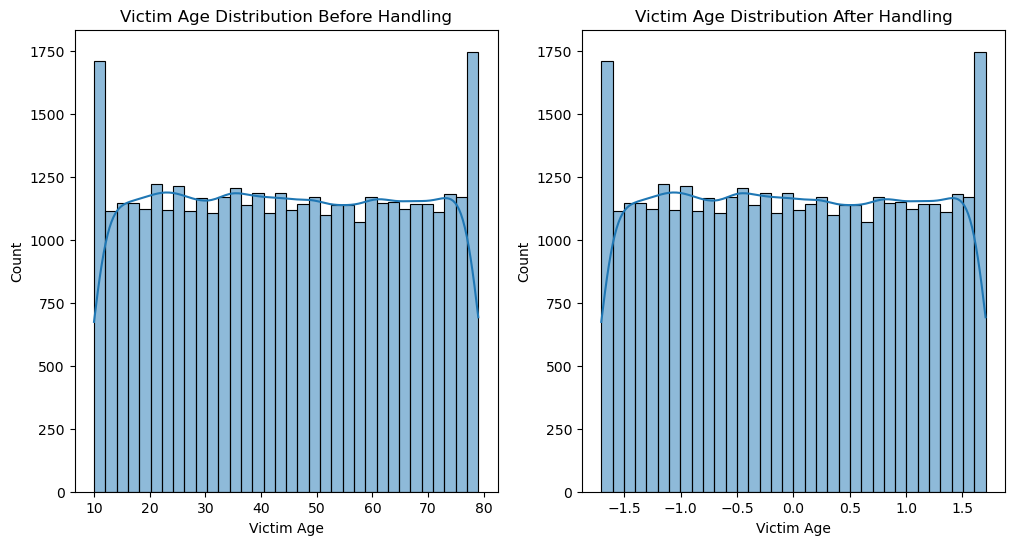

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reload raw data for "before" comparison
raw_data = pd.read_csv('crime_dataset_india.csv')  # Replace with your actual file name

# Before Handling: Missing Data Heatmap
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(raw_data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Before Handling')

# After Handling: Missing Data Heatmap (should be all filled)
plt.subplot(1, 2, 2)
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data After Handling')

plt.show()

# Impact on Distribution (e.g., for 'Victim Age' — shows how imputation affects spread)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(raw_data['Victim Age'], kde=True)  # Before (with missing)
plt.title('Victim Age Distribution Before Handling')

plt.subplot(1, 2, 2)
sns.histplot(df['Victim Age'], kde=True)  # After
plt.title('Victim Age Distribution After Handling')

plt.show()

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Features and Target for Classification
X_class = df.drop(['Crime Prone', 'Crime Count'], axis=1)  # Drop targets
y_class = df['Crime Prone']

X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

# Train SVM
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_class, y_train_class)

# Predict and Evaluate
y_pred_class = svm_model.predict(X_test_class)
print("SVM Accuracy:", accuracy_score(y_test_class, y_pred_class))
print("\nClassification Report:")
print(classification_report(y_test_class, y_pred_class))

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Features and Target for Regression
X_reg = df.drop('Crime Count', axis=1)  # Drop target
y_reg = df['Crime Count']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_reg, y_train_reg)

# Predict and Evaluate
y_pred_reg = rf_model.predict(X_test_reg)
print("Random Forest MSE:", mean_squared_error(y_test_reg, y_pred_reg))
print("Random Forest R2 Score:", r2_score(y_test_reg, y_pred_reg))

# Save the model for deployment
joblib.dump(rf_model, 'crime_model.pkl')
print("Model saved as 'crime_model.pkl'")

Random Forest MSE: 0.0
Random Forest R2 Score: 1.0
Model saved as 'crime_model.pkl'
